# `CLOUD.jl` - 1D linear advection-diffusion example

In [143]:
using CLOUD, OrdinaryDiffEq, Plots

Define the physical problem

In [144]:
a = 1.0  # wave speed
b = 1.0e-3 # diffusion coefficient

A = 1.0  # amplitude
L = 1.0  # domain length
σ = 0.01  # width of Gaussian pulse
x₀ = 0.2  # centre of Gaussian pulse
T = 1.0  # end time for one period

initial_data = InitialDataGaussian(A,σ,x₀)
conservation_law = LinearAdvectionDiffusionEquation(a,b)
exact_solution = ExactSolution(conservation_law,initial_data,periodic=true);

Set discretization parameters

In [145]:
M = 10
p = 8
form = WeakConservationForm()
strategy = Lazy()

ode_algorithm = CarpenterKennedy2N54()
dt = 0.1*(L/M)/(a*(2*p+1));
write_interval = floor(Int, T/(dt*100));

Set up a `DGSEM` scheme with LGL quadrature of degree `p` with `M` elements

In [146]:
reference_approximation =ReferenceApproximation(
    DGSEM(p), Line(), volume_quadrature_rule=LGLQuadrature())

mesh = uniform_periodic_mesh(
    reference_approximation.reference_element, (0.0,L), M)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), Lazy(),
     "results/advection_diffusion_1d_dgsem/", overwrite=true, clear=true);

Run the solver and plot the solution

In [147]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy)
save_solution(ode_problem.u0, 0.0, results_path, 0)
CLOUD_reset_timer()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, write_interval))
CLOUD_print_timer()

save_solution(last(sol.u), last(sol.t), results_path, "final")

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:          176μs / 789846.0%        23.3KiB / 3118218.5%  

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 primary variable       85.0k    772ms   55.6%  9.09μs    438MiB   61.7%  5.28KiB
   apply operators      85.0k    237ms   17.1%  2.79μs    112MiB   15.7%  1.34KiB
     volume terms       85.0k   53.8ms    3.9%   633ns   35.0MiB    4.9%     432B
     mass matrix solve  85.0k   35.3ms    2.5%   416ns   20.8MiB    2.9%     256B
     facet terms        85.0k   22.2ms    1.6%   262ns   6.49MiB    0.9%    80.0B
   eval visc num flux   85.0k    162ms   11.7%  1.91μs   79.1MiB   11.1%     976B
   eval flux   

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [148]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T)...)
println("Conservation (initial/final/diff):")
println(analyze(conservation_analysis)...)
println("Energy (initial/final/diff):")
println(analyze(energy_analysis)...)

L2 error:
4.041404997930092e-5
Conservation (initial/final/diff):
[0.025054134309542155][0.02505413430954249][3.365363543395006e-16]
Energy (initial/final/diff):
[0.008840408530187305][0.0019315166403796873][-0.006908891889807618]


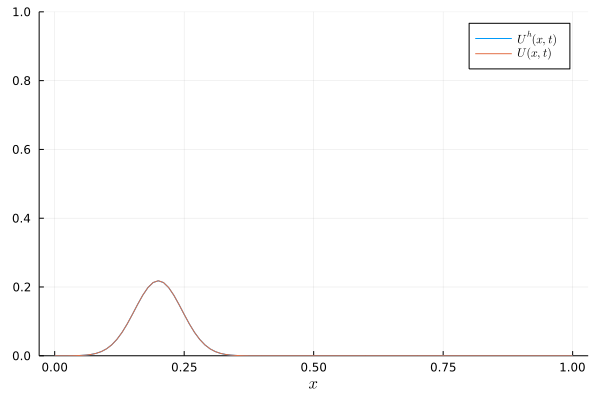

In [151]:
plot(spatial_discretization, last(sol.u), 
    exact_solution=exact_solution, time=T, ylims=[0.0,1.0])

┌ Info: Saved animation to 
│   fn = /Users/tristanmontoya/Research/CLOUD.jl/examples/advection_diffusion_solution.gif
└ @ Plots /Users/tristanmontoya/.julia/packages/Plots/gl4j3/src/animation.jl:137


Plots.AnimatedGif("/Users/tristanmontoya/Research/CLOUD.jl/examples/advection_diffusion_solution.gif")
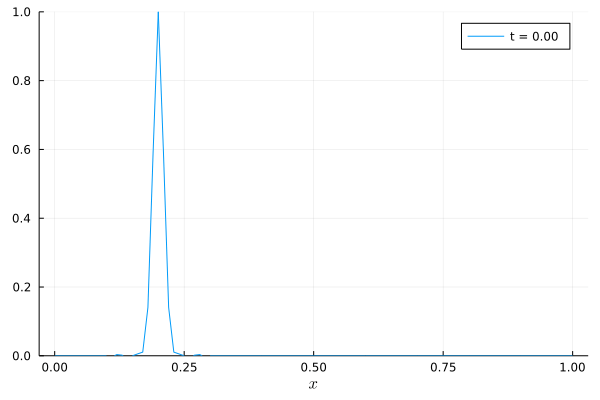

In [150]:
using Printf
anim = @animate for i ∈ eachindex(sol.u)
    plot(spatial_discretization, sol.u[i], ylims=[0.0,1.0], label=string("t = ", @sprintf "%.2f" sol.t[i]))
end
gif(anim, "advection_diffusion_solution.gif", fps = 10)